In [1]:
import seaborn as sns
from queries import*
from utilities import*

# Thresholding for all patients

In [5]:
Directory = os.getcwd()
Directory_path = Directory + '/data/input'
files = os.listdir(Directory_path)

for file in files[28:]:
    
    array = file.split('_')
    if len(array):
        condition = array[0]
        PATIENT_ID = array[1]
    else:
        condition == ''
        
    
    if condition == 'DEEPMEL':
        
        print('Treating patient' + PATIENT_ID)

        
        INPUT_PATH = './data/input/DEEPMEL_' + PATIENT_ID + '/'
        OUTPUT_PATH = './data/output/DEEPMEL_' + PATIENT_ID +'/'
        PLOT_PATH ='./plots/DEEPMEL_' + PATIENT_ID +'/'
        INPUT_FILE = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data.csv'
        TABLE_NAME_BQ = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data'
        COEF = 1.5
        DETERMINISTIC_CUTTING = True
        REAL_THRESHOLDING = False
        
        #cell_data = pd.read_csv(INPUT_PATH+INPUT_FILE)
        
        total_edges = pd.read_csv(OUTPUT_PATH + 'edges_thrd_35.csv')
        total_edges['phenotype_1'] = total_edges['phenotype_1'].apply(lambda x: get_phenotype(x))
        total_edges['phenotype_2'] = total_edges['phenotype_2'].apply(lambda x: get_phenotype(x))
        
        print('Dividing...')
        
        N = len(total_edges)
        r = int((N/1000)/1000)+1 
        q = [int(c) for c in np.linspace(0, N, r+2)]
        filtered_edges = pd.DataFrame({})
        
        print('Dividing to '+ str(len(q)) + ' parts, done')

        for index in range(len(q))[1:]:
            
            print('Treating part ', index)
            
            lower_bound = q[index-1]
            upper_bound = q[index]
            
            total_edges_part = total_edges[lower_bound:upper_bound]
            
            if REAL_THRESHOLDING  :
                axis_data = pd.read_csv('./data/input/axis_data_'+PATIENT_ID+'.csv')
                columns_to_keep = ['Cell ID','average_axis']
                axis_data = axis_data[columns_to_keep]
                cell_data = pd.read_csv(OUTPUT_PATH+'nodes_with_border.csv')
                edges = total_edges_part.merge(axis_data, left_on = 'cell_id_1', right_on='Cell ID', how='left')
                edges = edges.merge(axis_data, left_on = 'cell_id_2', right_on='Cell ID', how='left')
                edges['thrd'] = COEF* (edges['average_axis_x']+edges['average_axis_y'])
                edges = edges[edges.apply(lambda x: x.distance <= x.thrd, axis=1)]
    
            else:     
                 if DETERMINISTIC_CUTTING:
                    
                    median_thrd = pd.read_csv('./data/input/median.csv')
                    total_edges_part = total_edges_part.merge(median_thrd, left_on = 'phenotype_1', right_on='phenotype', how='left')
                    total_edges_part = total_edges_part.merge(median_thrd, left_on = 'phenotype_2', right_on='phenotype', how='left')
                    total_edges_part  = total_edges_part.drop(['phenotype_x','phenotype_y'], axis=1)
                    total_edges_part['threshold'] =  COEF*(total_edges_part['median_x'] + total_edges_part['median_y'])
                    edges = total_edges_part[total_edges_part.apply(lambda x: x.distance <= x.threshold, axis=1)]
    
                 else:
            
                    axis_data = pd.read_csv('./data/input/axis_data_'+PATIENT_ID+'.csv')
                    phenomaps = get_average_axis_list(axis_data)
                    total_edges_part['average_axis_1'] = total_edges_part['phenotype_1'].apply(lambda x : generate_axis(phenomaps,x))
                    total_edges_part['average_axis_2'] = total_edges_part['phenotype_2'].apply(lambda x : generate_axis(phenomaps,x))
                    total_edges_part['total_average'] = COEF* (total_edges_part['average_axis_2']+total_edges_part['average_axis_1'])
                    edges = total_edges_part[total_edges_part.apply(lambda x: x.distance <= x.total_average, axis=1)]
                
            print('Thresholding part ', str(index) ,': done !')
        
        
            edges = edges.drop(['median_x','median_y'],axis=1)
            filtered_edges = pd.concat([filtered_edges,edges])
        
        
        filtered_edges.to_csv(OUTPUT_PATH +'/graph_edges.csv', index = False)
        
        print('Saving done !')


Treating patient1C1
Dividing...
Dividing to 8 parts, done
Treating part  1
Thresholding part  1 : done !
Treating part  2
Thresholding part  2 : done !
Treating part  3
Thresholding part  3 : done !
Treating part  4
Thresholding part  4 : done !
Treating part  5
Thresholding part  5 : done !
Treating part  6
Thresholding part  6 : done !
Treating part  7
Thresholding part  7 : done !
Saving done !
Treating patient2L1
Dividing...
Dividing to 30 parts, done
Treating part  1
Thresholding part  1 : done !
Treating part  2
Thresholding part  2 : done !
Treating part  3
Thresholding part  3 : done !
Treating part  4
Thresholding part  4 : done !
Treating part  5
Thresholding part  5 : done !
Treating part  6
Thresholding part  6 : done !
Treating part  7
Thresholding part  7 : done !
Treating part  8
Thresholding part  8 : done !
Treating part  9
Thresholding part  9 : done !
Treating part  10
Thresholding part  10 : done !
Treating part  11
Thresholding part  11 : done !
Treating part  12
T

# Reading data

In [ ]:
PATIENT_ID = '1C1'
INPUT_PATH = './data/input/DEEPMEL_' + PATIENT_ID + '/'
OUTPUT_PATH = './data/output/DEEPMEL_' + PATIENT_ID +'/'
PLOT_PATH ='./plots/DEEPMEL_' + PATIENT_ID +'/'
INPUT_FILE = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data.csv'
TABLE_NAME_BQ = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data'
EDGE_THRD = 16
COEF =1.5
DETERMINISTIC_CUTTING = True
REAL_THRESHOLDING = False

## Nodes

In [3]:
cell_data = pd.read_csv(INPUT_PATH+INPUT_FILE)

## Edges: determinisic vs probabilistic cutting

In [14]:
total_edges.phenotype_1.value_counts()

tumor          4098717
stroma          847858
T               449083
B               142568
dendtritic      130293
MISSING          73177
macrophages       8729
NK                5864
Name: phenotype_1, dtype: int64

In [5]:
total_edges = pd.read_csv(OUTPUT_PATH + 'edges_thrd_35.csv')
total_edges['phenotype_1'] = total_edges['phenotype_1'].apply(lambda x: get_phenotype(x))
total_edges['phenotype_2'] = total_edges['phenotype_2'].apply(lambda x: get_phenotype(x))

if REAL_THRESHOLDING  :
    axis_data = pd.read_csv('./data/input/axis_data_'+PATIENT_ID+'.csv')
    columns_to_keep = ['Cell ID','average_axis']
    axis_data = axis_data[columns_to_keep]
    cell_data = pd.read_csv(OUTPUT_PATH+'nodes_with_border.csv')
    edges = total_edges.merge(axis_data, left_on = 'cell_id_1', right_on='Cell ID', how='left')
    edges = edges.merge(axis_data, left_on = 'cell_id_2', right_on='Cell ID', how='left')
    edges['thrd'] = COEF* (edges['average_axis_x']+edges['average_axis_y'])
    edges = edges[edges.apply(lambda x: x.distance <= x.thrd, axis=1)]
    
else:     
    if DETERMINISTIC_CUTTING:
        median_thrd = pd.read_csv('./data/input/median.csv')
        thresholding_df = total_edges.merge(median_thrd, left_on = 'phenotype_1', right_on='phenotype', how='left')
        thresholding_df = thresholding_df.merge(median_thrd, left_on = 'phenotype_2', right_on='phenotype', how='left')
        thresholding_df=thresholding_df.drop(['phenotype_x','phenotype_y'], axis=1)
        thresholding_df['threshold'] =  COEF*(thresholding_df['median_x'] + thresholding_df['median_y'])
        edges = thresholding_df[thresholding_df.apply(lambda x: x.distance <= x.threshold, axis=1)]
    
    else:
        axis_data = pd.read_csv('./data/input/axis_data_'+PATIENT_ID+'.csv')
        phenomaps = get_average_axis_list(axis_data)
        total_edges['average_axis_1'] = total_edges['phenotype_1'].apply(lambda x : generate_axis(phenomaps,x))
        total_edges['average_axis_2'] = total_edges['phenotype_2'].apply(lambda x : generate_axis(phenomaps,x))
        total_edges['total_average'] = COEF* (total_edges['average_axis_2']+total_edges['average_axis_1'])
        edges = total_edges[total_edges.apply(lambda x: x.distance <= x.total_average, axis=1)]

In [18]:
edges = edges.drop(['median_x','median_y'],axis=1)

In [19]:
edges.to_csv(OUTPUT_PATH +'/graph_edges.csv', index = False)

## Visualisation

In [104]:
#edges = graph_wrangling(total_edges, EDGE_THRD, False)

In [105]:
edges.head(6)

,distance,cell_id_1,cell_id_2,tissue_category_1,tissue_category_2,phenotype_1,phenotype_2,average_axis_1,average_axis_2,total_average
2,13.122881,79853,79902,stroma,stroma,stroma,stroma,7.345,6.710,21.0825
3,13.645878,37094,37150,stroma,stroma,stroma,stroma,7.625,6.710,21.5025
5,12.882546,78922,78956,tumor,tumor,stroma,tumor,7.155,9.925,25.6200
6,15.967780,664,715,tumor,tumor,stroma,stroma,9.155,5.230,21.5775
13,11.670904,9720,9724,stroma,stroma,stroma,stroma,10.780,4.185,22.4475
16,14.000714,45921,46001,tumor,tumor,stroma,tumor,6.455,9.685,24.2100


In [106]:
center_id = 664
center_x  = float(cell_data[cell_data.cell_id == center_id].cell_x_position.values)
center_y  = float(cell_data[cell_data.cell_id == center_id].cell_y_position.values)

In [107]:
cercle, points = cut_cercular_region(cell_data, center=[center_x,center_y], diameter = 100)

In [108]:
cercle_df = pd.DataFrame({})
cercle_df['cell_id'] = cercle
edges_in_cercle = edges.merge(cercle_df, left_on = 'cell_id_1', right_on='cell_id', how='left')
edges_in_cercle = edges_in_cercle.merge(cercle_df, left_on = 'cell_id_2', right_on='cell_id', how='left')
edges_in_cercle = edges_in_cercle[edges_in_cercle.isna().apply(lambda row: not(row.cell_id_x or row.cell_id_y), axis =1)]


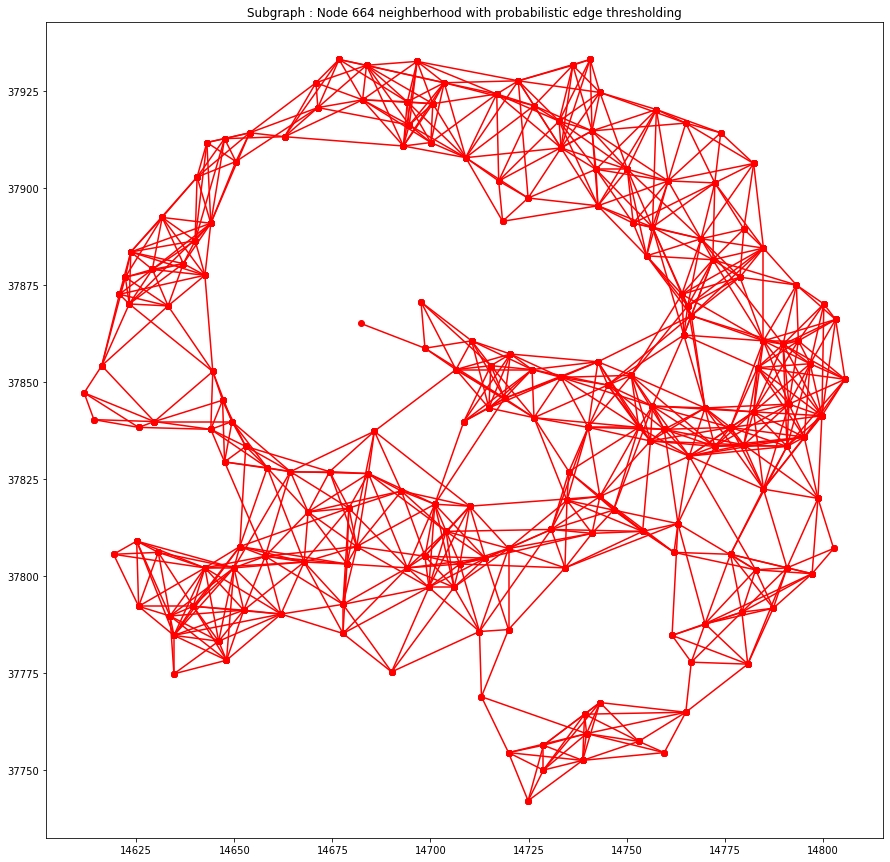

In [109]:
fig = plt.figure(figsize = (15,15))

for idx, row in edges_in_cercle.iterrows():
    

    
    cell_1 = row.cell_id_1
    cell_2 = row.cell_id_2
    
    cell_1_x = float(cell_data[cell_data.cell_id == cell_1].cell_x_position.values)
    cell_1_y = float(cell_data[cell_data.cell_id == cell_1].cell_y_position.values)
    
    
    cell_2_x = float(cell_data[cell_data.cell_id == cell_2].cell_x_position.values)
    cell_2_y = float(cell_data[cell_data.cell_id == cell_2].cell_y_position.values)
    
    
    x_values = [cell_1_x,cell_2_x]
    y_values = [cell_1_y,cell_2_y]
    
    plt.plot(x_values,y_values, '-ro')

if REAL_THRESHOLDING == True:
    
    fig.savefig(PLOT_PATH+str(center_id)+'Graph_neighberhood_real_major_minor_cutting.png')    
    plt.title('Subgraph : Node '+str(center_id)+ ' neighberhood with real minor/major axis thresholding edge thresholding')
    
else:    
    
    if DETERMINISTIC_CUTTING == False   :  
        fig.savefig(PLOT_PATH+str(center_id)+'Graph_neighberhood_probabilistic_cutting.png')
        plt.title('Subgraph : Node '+str(center_id)+ ' neighberhood with probabilistic edge thresholding')
    if DETERMINISTIC_CUTTING == True  :   
        fig.savefig(PLOT_PATH+str(center_id)+ 'Graph_neighberhood_deterministic_cutting.png')    
        plt.title('Subgraph : Node '+str(center_id)+ ' neighberhood with deterministic edge thresholding')


In [110]:
edge_x = []
edge_y = []
for idx, row in edges_in_cercle.iterrows():
    
    cell_1 = row.cell_id_1
    cell_2 = row.cell_id_2
    
    x0 = float(cell_data[cell_data.cell_id == cell_1].cell_x_position.values)
    y0 = float(cell_data[cell_data.cell_id == cell_1].cell_y_position.values)
    
    
    x1 = float(cell_data[cell_data.cell_id == cell_2].cell_x_position.values)
    y1 = float(cell_data[cell_data.cell_id == cell_2].cell_y_position.values)
    

    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
colors = []
phenotypes = []
color_mapping = {'tumor':'darkred', 'stroma':'peru',
                 'T':'springgreen', 'B':'turquoise','macrophages':'khaki',
                 'dendtritic':'orange', 'NK':'gray', 'MISSING' :'slategray'}  

for node in cercle:
    
    data = cell_data[cell_data.cell_id == node]
    x = float(data.cell_x_position.values)
    y = float(data.cell_y_position.values)
    phenotype = data.phenotype.values[0]
    color = color_mapping[data.phenotype.values[0]]
    node_x.append(x)
    node_y.append(y)
    colors.append(color)
    phenotypes.append(phenotype)
    
    


    
    
                     
                     
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color= [],
        size=10,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_trace.marker.color = colors
node_trace.text = phenotypes


KeyError: 'DAPIp'

In [ ]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=40,l=20,r=40,t=40),
                annotations=[ dict(
                    text="Patient_" +PATIENT_ID+ ' cell graph region' ,
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                width = 304,
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)) )
fig.show()